In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
from sqlalchemy import create_engine

"""Connection Details"""

user = "postgres"  # username
password = "tictok#2020"  # password
host = "localhost"  # server IP
port = "5432"  # port no
database = "warehouse_inventory"  # Data-Base name

try:
    engine = create_engine(
        f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}"
    )
    with engine.connect() as connection:
        print("Successfully connected to PostgreSQL Data-Base")

except Exception as exc:
    print("Error while connecting to PostgreSQL", exc)

Successfully connected to PostgreSQL Data-Base


#### Q1. Which items are at risk of stockout based on current stock and demand trends?

In [60]:
query_q1 = """
WITH
    last_month_qty_sold AS (
        SELECT
            item_id,
            SUM(sold_qty) AS qty_sold_last_month
        FROM
            sales
        WHERE
            sale_date BETWEEN '2025-06-01' AND '2025-06-30'
        GROUP BY
            item_id
    ),
    current_stock_demand AS (
        SELECT
            inv.item_id,
            inv.item_name,
            inv.current_stock,
            COALESCE(lmqs.qty_sold_last_month, 0) AS qty_sold_last_month,
            COALESCE(lmqs.qty_sold_last_month / 30, 0) AS avg_daily_demand
        FROM
            inventory inv
            LEFT JOIN last_month_qty_sold lmqs ON lmqs.item_id = inv.item_id
    )
SELECT
    item_id,
    item_name,
    current_stock,
    qty_sold_last_month,
    avg_daily_demand,
    CASE
        WHEN avg_daily_demand > 0 THEN current_stock / avg_daily_demand
        ELSE NULL
    END AS days_of_stock_left,
    CASE
        WHEN avg_daily_demand = 0 THEN 'No Demand'
        WHEN current_stock / avg_daily_demand <= 20 THEN 'High Risk'
        WHEN current_stock / avg_daily_demand <= 50 THEN 'Medium Risk'
        ELSE 'Low Risk'
    END AS stockout_risk
FROM
    current_stock_demand
ORDER BY
    days_of_stock_left;
"""

demand_trend = pd.read_sql(sql=query_q1, con=engine)
demand_trend.head()

,item_id,item_name,current_stock,qty_sold_last_month,avg_daily_demand,days_of_stock_left,stockout_risk
0,SKU_0099,Product 99,48,196,6,8.0,High Risk
1,SKU_0128,Product 128,58,188,6,9.0,High Risk
2,SKU_0064,Product 64,128,170,5,25.0,Medium Risk
3,SKU_0131,Product 131,192,213,7,27.0,Medium Risk
4,SKU_0076,Product 76,254,291,9,28.0,Medium Risk


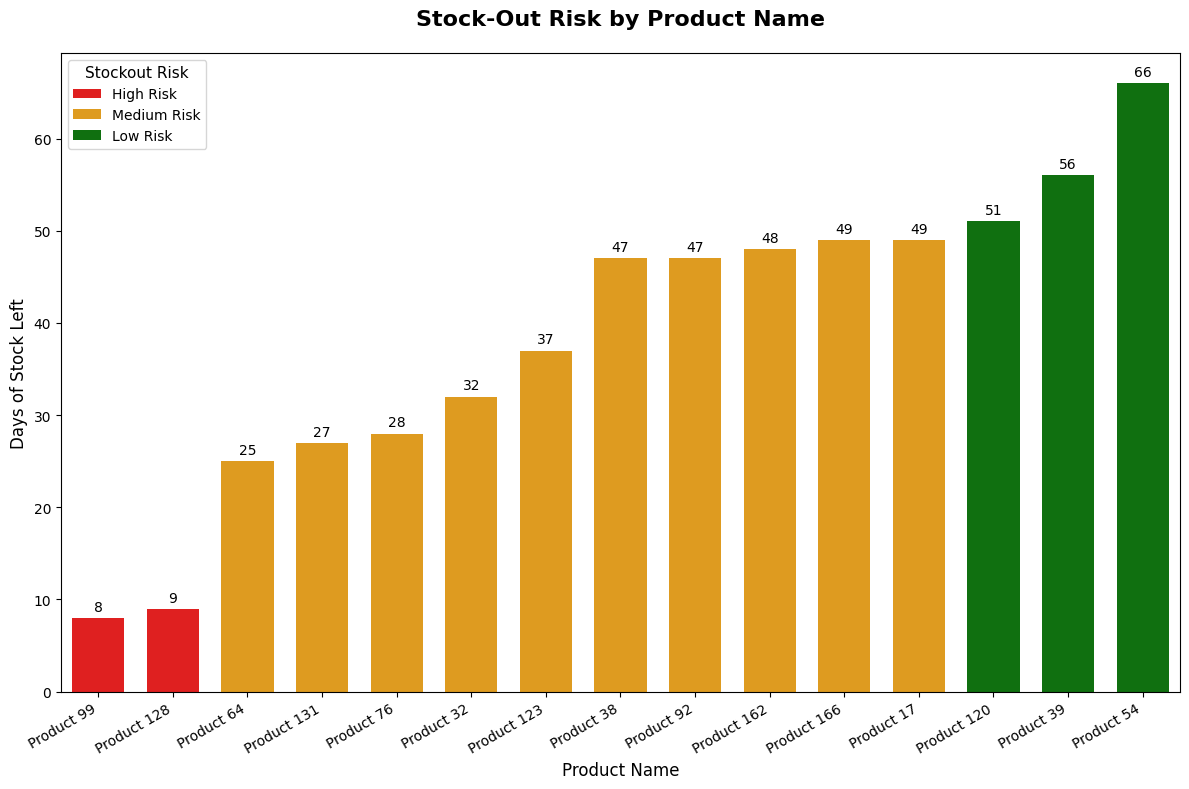

In [67]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=demand_trend.head(15),
    x="item_name",
    y="days_of_stock_left",
    hue="stockout_risk",
    palette=sns.blend_palette(["red", "orange", "green"], n_colors=3),
    width=0.7,
)

# Add labels to the plot
plt.title("Stock-Out Risk by Product Name", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Product Name", fontsize=12)
plt.ylabel("Days of Stock Left", fontsize=12)

# Add value labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=3, fontsize=10)

# Rotate x-axis labels
plt.xticks(rotation=30, ha="right")

# Adjust legend
plt.legend(title="Stockout Risk", title_fontsize=11, fontsize=10, loc="upper left")

plt.tight_layout()
plt.show()

#### Q2. How much inventory value is tied up in slow-moving or dead stock?

In [22]:
query_q2 = """
WITH
    inventory_value AS (
        SELECT
            inv.item_id,
            SUM(inv.current_stock * inv.unit_cost) AS stock_value,
            MAX(sls.sale_date) AS sale_date
        FROM
            sales sls
            JOIN inventory inv ON inv.item_id = sls.item_id
        GROUP BY
            inv.item_id
    ),
    inventory_value_status AS (
        SELECT
            item_id,
            stock_value,
            sale_date,
            CASE
                WHEN sale_date <= '2025-03-31' THEN 'Slow Moving Stock'
                ELSE 'Fast Moving Stock'
            END AS stock_status
        FROM
            inventory_value
    )
SELECT
    stock_status,
    ROUND(SUM(stock_value) / 1000000, 2) AS stock_value_mn
FROM
    inventory_value_status
GROUP BY
    stock_status;
"""

inventory_value = pd.read_sql(sql=query_q2, con=engine)
inventory_value

,stock_status,stock_value_mn
0,Slow Moving Stock,266.78
1,Fast Moving Stock,2966.17


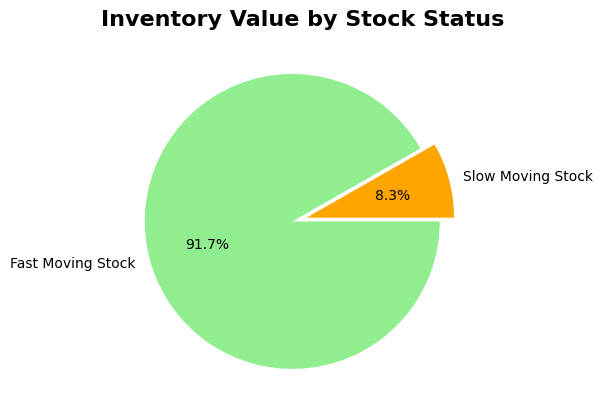

In [63]:
# Using pie chart to show the proportion of stock status in warehouse

plt.figure(figsize=(6, 6))
plt.pie(
    data=inventory_value,
    x="stock_value_mn",
    labels="stock_status",
    autopct="%1.1f%%",
    explode=(0, 0.1),
    colors=["orange", "lightgreen"],
)
plt.title("Inventory Value by Stock Status ", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()

##### Insights :
1. Over 91% of stock which is fast moving, could be due to low price, essential products which is used in day to day life or popularity of the brands among the customers.
2. 8.3% stock is identified as slow moving, In this category the products are more likely to be luxury goods or seasonal. 

3. In slow moving stock we have to identify why these products stuck at the warehouse and plan inventory accordingly.

#### Q3. Which SKUs are approaching expiry and require priority action?

In [ ]:
# Here '2025-06-30' is used as today's date.

query_q3 = """
WITH
    product_expiry AS (
        SELECT
            item_id,
            item_name,
            ROUND((current_stock * unit_cost)/1000,2) AS inventory_value_k,
            date_expiry,
            (date_expiry - '2025-06-30') AS days_in_expiry
        FROM
            inventory
    )
SELECT
    item_id,
    item_name,
    inventory_value_k,
    date_expiry,
    days_in_expiry,
    CASE
        WHEN days_in_expiry < 0 THEN 'Expired'
        WHEN days_in_expiry <= 30 THEN 'High Risk'
        WHEN days_in_expiry <= 90 THEN 'Medium Risk'
        WHEN days_in_expiry <= 180 THEN 'Low Risk'
        ELSE 'Safe'
    END AS expiry_status
FROM
    product_expiry
ORDER BY
    days_in_expiry;
"""

expiry_status = pd.read_sql(sql=query_q3, con=engine)
expiry_status.head()

,item_id,item_name,inventory_value_k,date_expiry,days_in_expiry,expiry_status
0,SKU_0053,Product 53,472.12,2025-07-01,1,High Risk
1,SKU_0021,Product 21,3405.11,2025-07-01,1,High Risk
2,SKU_0032,Product 32,15.74,2025-07-02,2,High Risk
3,SKU_0051,Product 51,1250.25,2025-07-03,3,High Risk
4,SKU_0030,Product 30,1214.85,2025-07-04,4,High Risk


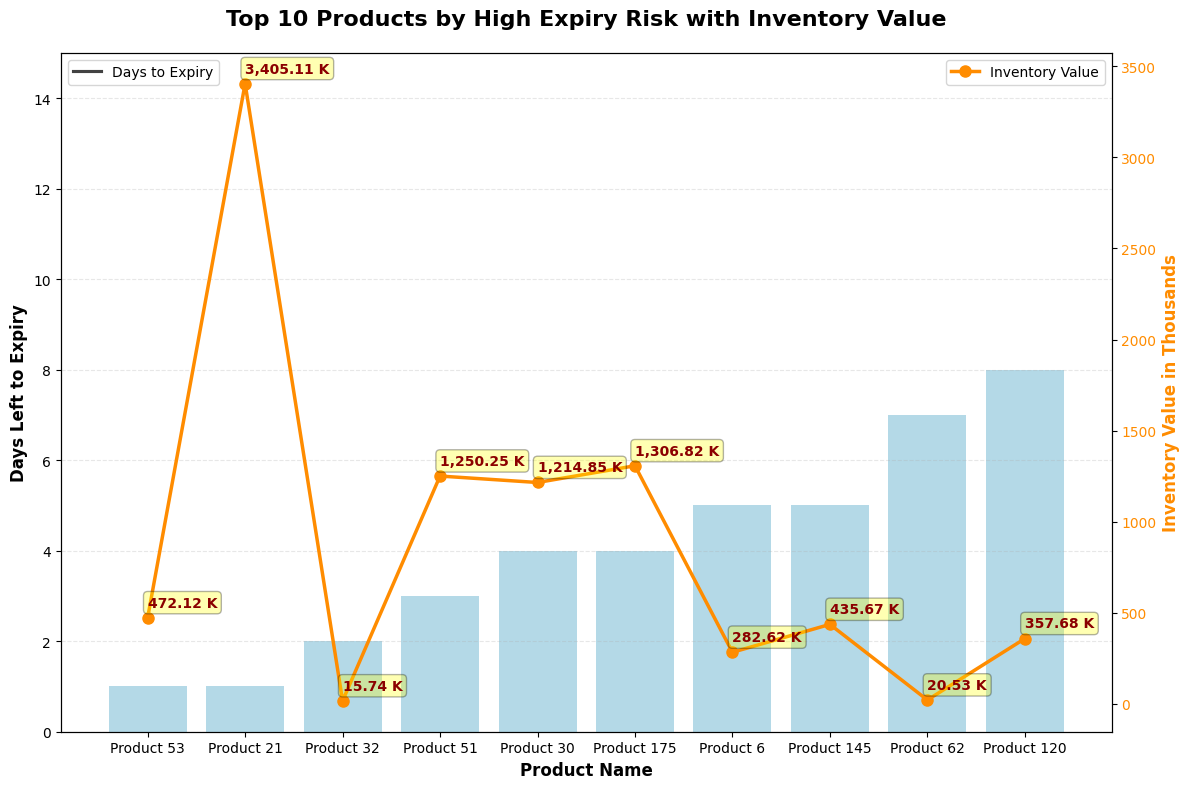

In [25]:
plt.figure(figsize=(12, 8))

# Bar plot for days to expiry
ax = sns.barplot(
    data=expiry_status.head(10),
    x="item_name",
    y="days_in_expiry",
    color="skyblue",
    alpha=0.7,  # Add transparency for better layering
)

# Titles and labels
plt.title(
    "Top 10 Products by High Expiry Risk with Inventory Value",
    fontsize=16,
    fontweight="bold",
    pad=20,  # Add padding above title
)
ax.set_xlabel("Product Name", fontsize=12, fontweight="bold")
ax.set_ylabel("Days Left to Expiry", fontsize=12, fontweight="bold")
ax.set_ylim(0, 15)
ax.grid(axis="y", alpha=0.3, linestyle="--")  # Add subtle gridlines

# Second axis for inventory value
ax2 = ax.twinx()
y_vals = expiry_status.head(10)["inventory_value_k"]

# Use numeric positions for proper alignment
line = ax2.plot(
    range(len(y_vals)),
    y_vals,
    marker="o",
    markersize=8,
    linestyle="-",
    linewidth=2.5,
    color="darkorange",
    label="Inventory Value",
)
ax2.set_ylabel(
    "Inventory Value in Thousands", fontsize=12, fontweight="bold", color="darkorange"
)
ax2.tick_params(axis="y", labelcolor="darkorange")

# Add value labels with better positioning
for i, y in enumerate(y_vals):
    ax2.annotate(
        f"{y:,.2f} K",  # Format with comma separator
        xy=(i, y),
        xytext=(0, 8),  # Offset above point
        textcoords="offset points",
        ha="left",
        fontsize=10,
        color="darkred",
        fontweight="bold",
        bbox=dict(
            boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.3
        ),  # Background box
    )

# Add legend
ax.legend(["Days to Expiry"], loc="upper left")
ax2.legend(["Inventory Value"], loc="upper right")

plt.tight_layout()
plt.show()

##### Insights:
1. Some products are near to expiry and those products need immediate attention.

2. Product 21 is near to it's expiry date, and has the highest inventory value.

3. For stock clearence we can introduce new discount offers and promotions strategy to clear the stocks.

#### Q4. What is the current inventory turnover rate, and which categories perform the best or worst?

In [26]:
query_q4 = """
WITH
    sales_cogs AS (
        SELECT
            inv.item_id,
            inv.category,
            SUM(inv.current_stock * inv.unit_cost) AS inventory_value,
            SUM(sls.sold_qty) AS total_sold_qty,
            MIN(inv.unit_cost) AS unit_cost,
            SUM(sls.sold_qty * inv.unit_cost) AS cogs
        FROM
            inventory inv
            JOIN sales sls ON (sls.item_id = inv.item_id)
        GROUP BY
            inv.item_id,
            inv.category
    ),
    inventory_turnover_per_item AS (
        SELECT
            item_id,
            category,
            inventory_value,
            cogs,
            ROUND(
                CASE
                    WHEN inventory_value > 0 THEN cogs / (
                        SELECT
                            AVG(inventory_value)
                        FROM
                            sales_cogs
                    )
                    ELSE 0
                END,
                2
            ) AS inventory_turnover_rate
        FROM
            sales_cogs
    )
SELECT
    category,
    ROUND(AVG(inventory_turnover_rate), 2) AS inventory_turnover_rate
FROM
    inventory_turnover_per_item
GROUP BY
    category;
"""

inventory_turnover = pd.read_sql(sql=query_q4, con=engine)
inventory_turnover

,category,inventory_turnover_rate
0,Electronics,0.12
1,Food,0.10
2,Household,0.11
3,Pharma,0.08
4,Automotive,0.08


In [27]:
print(
    f"Overall Inventory Turnover Rate {round(inventory_turnover["inventory_turnover_rate"].mean(),2)}"
)

Overall Inventory Turnover Rate 0.1


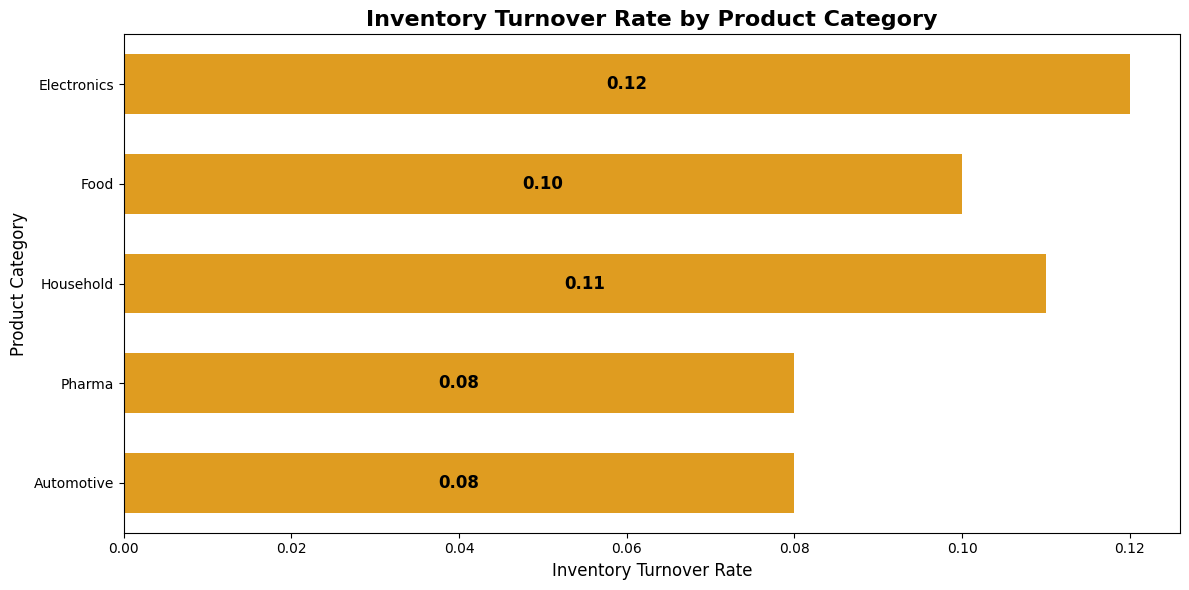

In [68]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=inventory_turnover,
    x="inventory_turnover_rate",
    y="category",
    color="orange",
    width=0.6,
)

# Add bar labels at the center of each bar
for i, bar in enumerate(ax.patches):
    width = bar.get_width()
    ax.text(
        width / 2,  # Position at the middle of the bar
        bar.get_y() + bar.get_height() / 2,  # Center vertically
        f"{width:.2f}",  # Format to 2 decimal places
        ha="center",  # Center alignment horizontally
        va="center",  # Center alignment vertically
        fontsize=12,
        fontweight="bold",
        color="black",  # White text for contrast against orange
    )

plt.title("Inventory Turnover Rate by Product Category", fontsize=16, fontweight="bold")
plt.xlabel("Inventory Turnover Rate", fontsize=12)
plt.ylabel("Product Category", fontsize=12)
plt.tight_layout()
plt.show()

##### Insights :
1. Electronics performing best when compare to rest of the other categories. It's high turnover rate 0.12 indicate that electronics products stock movement is fast.

2. Worst Performing categories are Pharma and Automotive in all the categories with turnover rate 0.8 for each. 

3. Low turnover rate suggest that these product more likely to sit in warehouse compared to other categories.

4. We should plan our inventory purchase accordingly.